# Explore here

In [47]:
#Los IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import json
import random
import pickle 

import requests
import zipfile
import io

import os
from PIL import Image
import shutil
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model



In [ ]:
#Importar desde ZIP al proyecto y descomprimir
url = "https://storage.googleapis.com/datascience-materials/dogs-vs-cats.zip"
response = requests.get(url)
response.raise_for_status()
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    z.extractall("/workspaces/Leonel_Ponce_Deep_learning_project/data/Repertorio")

In [6]:
#Visualizamos los primeras 9 imágenes de perros
origen = "/workspaces/Leonel_Ponce_Deep_learning_project/data/Repertorio/dogs-vs-cats/all"

perretes = [f for f in os.listdir(origen) if f.startswith("dog")] #Filtramos por perros
dog = perretes[:9]

plt.figure(figsize=(10, 10))
for i, filename in enumerate(dog):
    img_path = os.path.join(origen, filename)
    img = Image.open(img_path)

    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(filename)
    plt.axis("off")

plt.tight_layout()
plt.show()

<Figure size 1000x1000 with 0 Axes>

In [7]:
#Visualizamos los primeras 9 imágenes de gatos
origen = "/workspaces/Leonel_Ponce_Deep_learning_project/data/Repertorio/dogs-vs-cats/all"
michis = [f for f in os.listdir(origen) if f.startswith("cat")] #Filtramos por perros
cat = michis[:9]

plt.figure(figsize=(10, 10))
for i, filename in enumerate(cat):
    img_path = os.path.join(origen, filename)
    img = Image.open(img_path)

    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(filename)
    plt.axis("off")

plt.tight_layout()
plt.show()

<Figure size 1000x1000 with 0 Axes>

In [8]:
#Ordenamos directorio para analizar
origen = "/workspaces/Leonel_Ponce_Deep_learning_project/data/Repertorio/dogs-vs-cats/all" 

#Crear carpetas
train_perretes_folder = os.path.join(origen, "train/perretes")
train_michis_folder   = os.path.join(origen, "train/michis")
test_perretes_folder  = os.path.join(origen, "test/perretes")
test_michis_folder    = os.path.join(origen, "test/michis")

for folder in [train_perretes_folder, train_michis_folder, test_perretes_folder, test_michis_folder]:
    os.makedirs(folder, exist_ok=True)

# Listar imágenes sueltas
ima_complete = [f for f in os.listdir(origen) if f.lower().endswith((".jpg", ".jpeg", ".png"))]

# Separar por clase según nombre
perretes = [img for img in ima_complete if img.startswith("dog")]
michis = [img for img in ima_complete if img.startswith("cat")]

In [9]:
#Separamos en train y test
train_perretes, test_perretes = train_test_split(perretes, test_size=0.2, random_state=42)
train_michis, test_michis = train_test_split(michis, test_size=0.2, random_state=42)

def mover(lista, destino):
    for img in lista:
        shutil.move(os.path.join(origen, img),
                    os.path.join(destino, img))

mover(train_perretes, train_perretes_folder)
mover(test_perretes,  test_perretes_folder)
mover(train_michis,   train_michis_folder)
mover(test_michis,    test_michis_folder)


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [10]:
nombre_ima = os.listdir(origen)
etiquetas = [0 if f.startswith("cat") else 1 for f in nombre_ima]  # 0 = gato, 1 = perro

train_files, test_files, train_labels, test_labels = train_test_split(
    nombre_ima, etiquetas, test_size=0.2, random_state=42, stratify=etiquetas
)

print("Train:", len(train_files), "Test:", len(test_files))

Train: 1 Test: 1


In [11]:
#Enlistar imágenes del dataset
ima_complete = os.listdir(origen)
perretes = [f for f in ima_complete if f.startswith("dog")]
gatetes = [f for f in ima_complete if f.startswith("cat")]

#Dividimos el dataset y movemos según categoria
def split_and_move(images, label):
    random.shuffle(images)
    split_idx = int(0.8 * len(images))  # 80% train, 20% test
    train_ima = images[:split_idx]
    test_ima = images[split_idx:]
    
    
    for img in train_ima:
        shutil.copy(os.path.join(origen, img), os.path.join(origen, "train", label, img))
    for img in test_ima:
        shutil.copy(os.path.join(origen, img), os.path.join(origen, "test", label, img))

split_and_move(perretes, "dog")
split_and_move(gatetes, "cat")

In [12]:

trn_database = ImageDataGenerator(rescale=1./255)
tst_database = ImageDataGenerator(rescale=1./255)

train_database = trn_database.flow_from_directory(
    "/workspaces/Leonel_Ponce_Deep_learning_project/data/Repertorio/dogs-vs-cats/all/train",              
    target_size=(170, 170),    
    batch_size=8,             
    class_mode="binary"        
)

test_database = tst_database.flow_from_directory(
    "/workspaces/Leonel_Ponce_Deep_learning_project/data/Repertorio/dogs-vs-cats/all/test",  
    target_size=(170, 170),
    batch_size=8,
    class_mode="binary"
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [13]:
# Información de clases
print("Clases y sus índices:", train_database.class_indices)

# Etiquetas de train y test
train_labels = train_database.classes
test_labels  = test_database.classes

print("Total imágenes en train:", len(train_labels))
print("Distribución por clase en train:", Counter(train_labels))

print("Total imágenes en test:", len(test_labels))
print("Distribución por clase en test:", Counter(test_labels))


Clases y sus índices: {'michis': 0, 'perretes': 1}
Total imágenes en train: 20000
Distribución por clase en train: Counter({np.int32(0): 10000, np.int32(1): 10000})
Total imágenes en test: 5000
Distribución por clase en test: Counter({np.int32(0): 2500, np.int32(1): 2500})


In [18]:
#Definiendo un modelo
model = Sequential([
    Conv2D(16, (3,3), activation="relu", input_shape=(170,170,3)),
    MaxPooling2D(2,2),

    Conv2D(32, (3,3), activation="relu"),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

/home/vscode/.local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
#Confirgurar el aprendizaje del modelo
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

Epoch 8/10 --- 2500/2500 ━━━━ 513s 186ms/step - accuracy: 0.9635 - loss: 0.1007 - val_accuracy: 0.7774 - val_loss: 0.9307
--------
Epoch 9/10 --- 1760/2500 ━━━━━━━━━━━━━━━━━━━━ 1:52 152ms/step - accuracy: 0.9698 - loss: 0.0831
--------
Se acaba la memoria en el epoch 9/10, conforme sube en el epoch mejora el accuracy, lo detendré en el epoch 7

In [ ]:
history = model.fit(
    train_database,    
    validation_data=test_database,
    epochs=7
)

# Se establece EarlyStopping
early_stop = EarlyStopping(
    monitor="val_loss",     
    patience=5,              
    restore_best_weights=True
)

# Entrenar el modelo con el callback
history = model.fit(
    train_database,    
    validation_data=test_database,
    epochs=7,               
    callbacks=[early_stop]    
)

Epoch 1/7
   2/2500 ━━━━━━━━━━━━━━━━━━━━ 5:54 142ms/step - accuracy: 0.5625 - loss: 1.5208

2025-11-24 08:05:14.496406: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 27111168 exceeds 10% of free system memory.
2025-11-24 08:05:14.604096: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 27111168 exceeds 10% of free system memory.


   3/2500 ━━━━━━━━━━━━━━━━━━━━ 10:50 261ms/step - accuracy: 0.5556 - loss: 1.7226

2025-11-24 08:05:15.007740: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 27111168 exceeds 10% of free system memory.


   4/2500 ━━━━━━━━━━━━━━━━━━━━ 13:00 313ms/step - accuracy: 0.5339 - loss: 1.8183

2025-11-24 08:05:15.425750: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 27111168 exceeds 10% of free system memory.


   5/2500 ━━━━━━━━━━━━━━━━━━━━ 14:44 355ms/step - accuracy: 0.5271 - loss: 1.8303

2025-11-24 08:05:15.912466: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 27111168 exceeds 10% of free system memory.


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 323s 128ms/step - accuracy: 0.6492 - loss: 0.6331 - val_accuracy: 0.7026 - val_loss: 0.5731
Epoch 2/7
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 301s 120ms/step - accuracy: 0.7479 - loss: 0.5202 - val_accuracy: 0.6988 - val_loss: 0.5860
Epoch 3/7
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 303s 121ms/step - accuracy: 0.7965 - loss: 0.4404 - val_accuracy: 0.7612 - val_loss: 0.5046
Epoch 4/7
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 314s 118ms/step - accuracy: 0.8393 - loss: 0.3627 - val_accuracy: 0.7580 - val_loss: 0.5202
Epoch 5/7
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 299s 120ms/step - accuracy: 0.8769 - loss: 0.2889 - val_accuracy: 0.7772 - val_loss: 0.5496
Epoch 6/7
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 322s 120ms/step - accuracy: 0.9104 - loss: 0.2255 - val_accuracy: 0.7734 - val_loss: 0.6057
Epoch 7/7
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 323s 120ms/step - accuracy: 0.9297 - loss: 0.1769 - val_accuracy: 0.7704 - val_loss: 0.7140
Epoch 1/7
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 300s 120ms/step - accuracy: 0.9437 - l

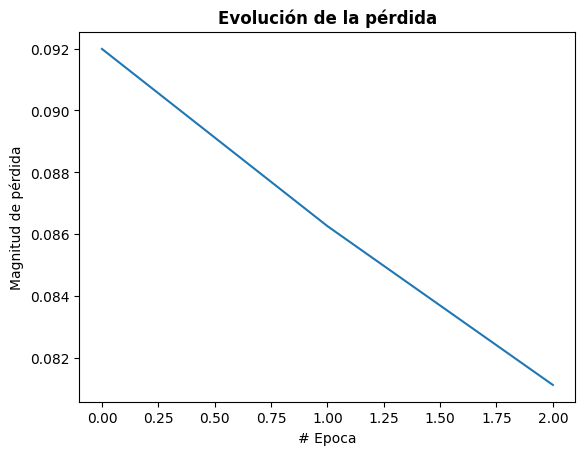

In [38]:

plt.title("Evolución de la pérdida", fontsize=12, fontweight="bold")
plt.xlabel("# Epoca")
plt.ylabel("Magnitud de pérdida")
plt.plot(history.history["loss"])

In [24]:
loss, acc = model.evaluate(test_database)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")

  2/625 ━━━━━━━━━━━━━━━━━━━━ 39s 64ms/step - accuracy: 0.9375 - loss: 0.2105

625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.7706 - loss: 0.8202
Test Loss: 0.8202
Test Accuracy: 0.7706


In [27]:
checkpoint = ModelCheckpoint(
    "models/best_model.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

earlystop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

In [30]:
history = model.fit(
    train_database,
    validation_data=test_database,
    epochs=7,
    callbacks=[checkpoint, earlystop]
)


Epoch 1/7


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9673 - loss: 0.0937
Epoch 1: val_accuracy did not improve from 0.77180
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 294s 118ms/step - accuracy: 0.9652 - loss: 0.0920 - val_accuracy: 0.7694 - val_loss: 1.1006
Epoch 2/7
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9673 - loss: 0.0798
Epoch 2: val_accuracy did not improve from 0.77180
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 292s 117ms/step - accuracy: 0.9667 - loss: 0.0863 - val_accuracy: 0.7692 - val_loss: 0.9744
Epoch 3/7
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9691 - loss: 0.0785
Epoch 3: val_accuracy did not improve from 0.77180
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 292s 117ms/step - accuracy: 0.9681 - loss: 0.0811 - val_accuracy: 0.7606 - val_loss: 1.4895


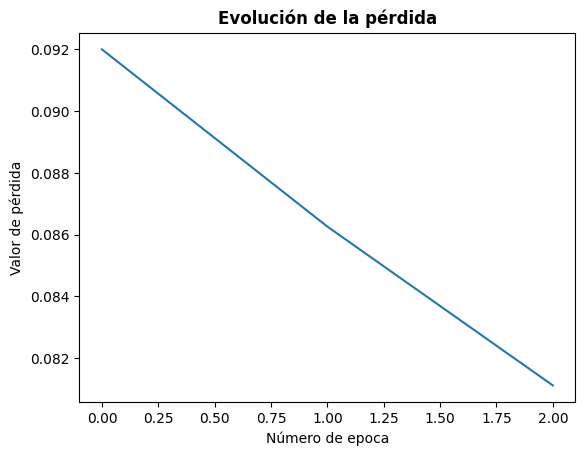

In [40]:
plt.title("Evolución de la pérdida", fontsize=12, fontweight="bold")
plt.xlabel("Número de epoca")
plt.ylabel("Valor de pérdida")
plt.plot(history.history["loss"], label="Loss entrenamiento")

In [42]:
loss, acc = model.evaluate(test_database)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")

  1/625 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - accuracy: 1.0000 - loss: 0.0253

625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step - accuracy: 0.7694 - loss: 1.1006
Test Loss: 1.1006
Test Accuracy: 0.7694


In [49]:
mejor_modelo = load_model("models/best_model.keras")

with open("models/mejor_modelo.pkl", "wb") as f:
    pickle.dump(mejor_modelo, f)

Se ve claramente que aunque se establece un "mejor modelo" es deficiente en conjunto, mientras "accuracy" puede ser bueno, la pérdida no es mala, sin embargo cuando entra "val_accuracy" es cuando podemos ver que falta mejorse, estuve buscando información al respecto, y para mejorar el modelo indican aumentar capas por ejemplo, o en mi caso si tuviese más memoria, se aumentaria el tamaño de la imágen siendo que la tuve que reducir aun más de lo que se pedía inicialmente...